# Dataset seoul_bike_data - Modelo Escolhido - Previsão da Quantidade de Bicicletas Alugadas.

## Atividade Somativa 2.0 - Criando a sua própria IA: parte II.
## Contexto do projeto.
#### Nas semanas anteriores, desenvolvemos um notebook em Python para a primeira parte do processo seletivo de estágio em uma grande consultoria. Agora, na segunda parte, continuaremos trabalhando com o mesmo dataset de bicicletas compartilhadas em Seul, mas com algumas modificações e melhorias no fluxo de trabalho.
## Objetivo do projeto.
#### O objetivo desta segunda parte é demonstrar: Habilidade em reorganizar o fluxo de processamento de dados, implementação de pipelines para automatizar o processo, avaliação do modelo usando métricas apropriadas e capacidade de análise crítica dos resultados.

## Importação das Bibliotecas e Algoritmos Utilizados.
#### Esta célula importa as bibliotecas e os módulos necessários para a manipulação e análise de dados, visualização, pré-processamento, modelagem de machine learning e avalização de modelos.

In [1]:
# Bibliotecas de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Pré-processamento e modelagem
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Seleção de Features e modelo XGBoost
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
#Métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Visualização e dimensionamento do Dataset escolhido.
#### Etapa de compreenção da estrutura e suas características. (Carregando o Dataset)


In [2]:
# Carregando e lendo o dataset
df= pd.read_excel("C:/Users/Sherlock/Desktop/Machine learn/archive/seoul_bike_data.xlsx")
df.head()

# Visualizando as primeiras linhas
print("Dimensões do dataset:", df.shape)
df.head()

Dimensões do dataset: (8760, 13)


,DateTime,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
0,2017-01-12 00:00:00,12,5,0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,2017-01-12 01:00:00,12,5,1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,2017-01-12 02:00:00,12,5,2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,2017-01-12 03:00:00,12,5,3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,2017-01-12 04:00:00,12,5,4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0


## Realizando a divisão do dataset entre uma base de treinamento e de testes.

In [3]:
# Separando variáveis independentes e dependente
X = df.drop("Rented Bike Count", axis=1)
y = df["Rented Bike Count"]

# Divisão em conjuntos de treino (75%) e teste (25%)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

print(f"Tamanho do treino: {X_train.shape[0]} amostras")
print(f"Tamanho do teste: {X_test.shape[0]} amostras")

Tamanho do treino: 6570 amostras
Tamanho do teste: 2190 amostras


## Preparação dos tipos de dados e tratamento.

In [4]:
# Converter a coluna DateTime para datetime
X_train['DateTime'] = pd.to_datetime(X_train['DateTime'])
X_test['DateTime'] = pd.to_datetime(X_test['DateTime'])

In [5]:
# Processamento da DateTime APÓS a divisão 
def process_datetime(df):
    dt = pd.to_datetime(df['DateTime'])
    return pd.DataFrame({
        'Hour': dt.dt.hour,
        'DayOfWeek': dt.dt.dayofweek,
        'Month': dt.dt.month,
        'IsWeekend': dt.dt.dayofweek.isin([5, 6]).astype(int),
        'IsRushHour': dt.dt.hour.isin([7, 8, 17, 18, 19]).astype(int)
    }, index=df.index)

## Bases de Treino e Teste.

In [6]:
# Aplicar às bases de treino e teste
datetime_train = process_datetime(X_train)
datetime_test = process_datetime(X_test)

In [7]:
# Definir colunas para transformação
numeric_features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 
                   'Visibility (10m)', 'Dew point temperature(°C)', 
                   'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

categorical_features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsRushHour']

## Processamento dos dados e Pipeline.
#### - Pré-processamento dos dados (normalização numérica e codificação categórica)
#### - Início do Treinamento
#### - Seleção de features
#### - Modelo XGBoost

In [8]:
# Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [9]:
# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(XGBRegressor(random_state=42))),
    ('model', XGBRegressor(
        random_state=42,
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

In [10]:
# Preparar dados finais (remover DateTime original e juntar com features temporais)
X_train_final = pd.concat([
    X_train.drop('DateTime', axis=1),
    datetime_train
], axis=1)

X_test_final = pd.concat([
    X_test.drop('DateTime', axis=1),
    datetime_test
], axis=1)

In [11]:
# Remove colunas duplicadas
X_train_final = X_train_final.loc[:, ~X_train_final.columns.duplicated()]
X_test_final = X_test_final.loc[:, ~X_test_final.columns.duplicated()]

## Treinamento e Predição
#### Treinamento do pipeline e continuídade das predições.

In [12]:
# Treianemnto
pipeline.fit(X_train_final, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Temperature(°C)',
                                                   'Humidity(%)',
                                                   'Wind speed (m/s)',
                                                   'Visibility (10m)',
                                                   'Dew point temperature(°C)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Hour', 'DayOfWeek', 'Month',
                                                   'IsWeekend',
                                                   'IsRushHour'])])),
                ('featur...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [13]:
#Avaliação
y_pred = pipeline.predict(X_test_final)

## Métricas de Avaliação
#### Escolhi as métricas para avaliação do modelo de regressão:
#### - MAE (Mean Absolute Error)
#### - RMSE (Root Mean Squared Error)

In [14]:
# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("\nResultado das Métricas de Avaliação:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



Resultado das Métricas de Avaliação:
MAE: 214.67
RMSE: 344.46


## Conclusão da Equipe sobre as Métricas

#### Com base nos resultados obtidos, a equipe conclui que os valores das métricas de avaliação indicam um desempenho satisfatório do modelo, embora haja espaço para melhorias como: Aprimorar o pré-processamento, testar outros algoritmos de regressão, ajustar hiperparâmetros.

#### O MAE de 214,67 demonstra que o erro médio nas previsões é razoável, considerando a natureza do problema. Esse valor pode ser considerado bom, desde que esteja dentro de um intervalo tolerável para o domínio da aplicação (ex: se o total previsto for da ordem de milhares).
#### O RMSE de 344,46, por sua vez, sendo significativamente maior que o MAE, sugere que existem algumas previsões com erros maiores — possivelmente causadas por outliers ou variáveis não explicadas adequadamente.
#### Em resumo, os resultados são bons para uma primeira versão, mas com intervenções pontuais, é possível alcançar uma performance ainda melhor.

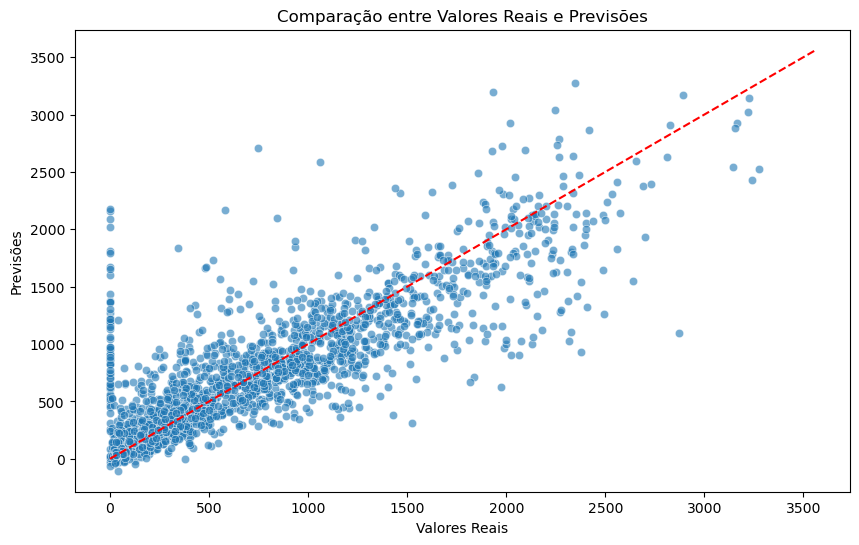

In [15]:
#Visualização
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Comparação entre Valores Reais e Previsões')
plt.show()

## Gráfico de dispersão: Valores reais (no eixo x) com Previsões (no eixo y)
#### O gráfico mostra como as previsões se comparam aos valores reais. Se a maioria dos pontos estiver próxima da linha diagonal, o modelo é considerado preciso.

## Resultado
#### - A maior parte dos pontos se concentra próxima da linha diagonal, o que indica que, em muitos casos, o modelo fez previsões próximas aos valores reais.
#### - Observam-se pontos dispersos acima e abaixo da linha, sugerindo que o modelo teve casos de superestimação e subestimação.
#### - Existe uma tendência central, mas com variação significativa em algumas faixas de valores (especialmente para valores reais mais altos, onde a dispersão aumenta).
#### - Não há formação clara de uma linha paralela à diagonal, o que sugere que não há viés constante evidente.
#### - A dispersão aleatória indica que os erros não seguem um padrão sistemático claro.

## Conclusão Final
#### O modelo de regressão implementado apresenta desempenho razoável, com boa capacidade de previsão para a maioria dos casos, especialmente nas faixas de valores mais comuns. No entanto, há uma dispersão maior em valores altos, o que sugere que o modelo perde um pouco de precisão nesses casos.

### Entende-se portando que como a maioria dos pontos permanece próxima à diagonal, conclui-se que o modelo é adequado e funcional.